## Урок 5. Part-of-Speech разметка, NER, извлечение отношений/ ДЗ

### Задание 1. Написать теггер на данных с русским языком
1.	проверить UnigramTagger, BigramTagger, TrigramTagger и их комбинации
2.	написать свой теггер как на занятии, попробовать разные векторайзеры, добавить знание не только букв но и слов
3.	сравнить все реализованные методы, сделать выводы  

### Задание 2. Проверить, насколько хорошо работает NER
Данные брать из Index of /pub/named_entities
1.	проверить NER из nltk/spacy/deeppavlov.
2.	написать свой NER, попробовать разные подходы.

a.	передаём в сетку токен и его соседей.

b.	передаём в сетку только токен.

c.	свой вариант.


3.	сравнить свои реализованные подходы на качество — вывести precision/recall/f1_score.


### Задание 1. Написать теггер на данных с русским языком

In [ ]:
!pip install pyconll

In [ ]:
!pip install -U spacy
!python -m spacy info
!python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.6.1
    Uninstalling spacy-3.6.1:
      Successfully uninstalled spacy-3.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.6.0 requires spacy<3.7.0,>=3.6.0, but you have spacy 3.7.2 which is incompatible.
2023-12-25 10:44:56.950768: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-25 10:44:56.950857: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Att

In [ ]:
import pyconll

import pandas as pd

import nltk
from nltk.tag import UnigramTagger, BigramTagger, TrigramTagger

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, classification_report


In [ ]:
full_train = pyconll.load_from_file('/content/ru_syntagrus-ud-dev/ru_syntagrus-ud-dev.conllu')
full_test = pyconll.load_from_file('/content/ru_syntagrus-ud-dev/ru_syntagrus-ud-train-a.conllu')

In [ ]:
for sent in full_train[:2]:
    for token in sent:
        print(token.form, token.upos)
    print()

Алгоритм NOUN
, PUNCT
от ADP
имени NOUN
учёного NOUN
аль PART
- PUNCT
Хорезми PROPN
, PUNCT
- PUNCT
точный ADJ
набор NOUN
инструкций NOUN
, PUNCT
описывающих VERB
порядок NOUN
действий NOUN
исполнителя NOUN
для ADP
достижения NOUN
результата NOUN
решения NOUN
задачи NOUN
за ADP
конечное ADJ
время NOUN
. PUNCT

В ADP
старой ADJ
трактовке NOUN
вместо ADP
слова NOUN
" PUNCT
порядок NOUN
" PUNCT
использовалось VERB
слово NOUN
" PUNCT
последовательность NOUN
" PUNCT
, PUNCT
но CCONJ
по ADP
мере NOUN
развития NOUN
параллельности NOUN
в ADP
работе NOUN
компьютеров NOUN
слово NOUN
" PUNCT
последовательность NOUN
" PUNCT
стали VERB
заменять VERB
более ADV
общим ADJ
словом NOUN
" PUNCT
порядок NOUN
" PUNCT
. PUNCT



In [ ]:
fdata_train = []
for sent in full_train[:]:
    fdata_train.append([(token.form, token.upos) for token in sent])

fdata_test = []
for sent in full_test[:]:
    fdata_test.append([(token.form, token.upos) for token in sent])

fdata_sent_test = []
for sent in full_test[:]:
    fdata_sent_test.append([token.form for token in sent])

In [ ]:
MAX_SENT_LEN = max(len(sent) for sent in full_train)
print('Наибольшая длина предложения', MAX_SENT_LEN)

Наибольшая длина предложения 144


In [ ]:
MAX_ORIG_TOKEN_LEN = max(len(token.form) for token in sent)
print('Наибольшая длина токена', MAX_ORIG_TOKEN_LEN)

Наибольшая длина токена 9


In [ ]:
fdata_train[:3]

[[('Алгоритм', 'NOUN'),
  (',', 'PUNCT'),
  ('от', 'ADP'),
  ('имени', 'NOUN'),
  ('учёного', 'NOUN'),
  ('аль', 'PART'),
  ('-', 'PUNCT'),
  ('Хорезми', 'PROPN'),
  (',', 'PUNCT'),
  ('-', 'PUNCT'),
  ('точный', 'ADJ'),
  ('набор', 'NOUN'),
  ('инструкций', 'NOUN'),
  (',', 'PUNCT'),
  ('описывающих', 'VERB'),
  ('порядок', 'NOUN'),
  ('действий', 'NOUN'),
  ('исполнителя', 'NOUN'),
  ('для', 'ADP'),
  ('достижения', 'NOUN'),
  ('результата', 'NOUN'),
  ('решения', 'NOUN'),
  ('задачи', 'NOUN'),
  ('за', 'ADP'),
  ('конечное', 'ADJ'),
  ('время', 'NOUN'),
  ('.', 'PUNCT')],
 [('В', 'ADP'),
  ('старой', 'ADJ'),
  ('трактовке', 'NOUN'),
  ('вместо', 'ADP'),
  ('слова', 'NOUN'),
  ('"', 'PUNCT'),
  ('порядок', 'NOUN'),
  ('"', 'PUNCT'),
  ('использовалось', 'VERB'),
  ('слово', 'NOUN'),
  ('"', 'PUNCT'),
  ('последовательность', 'NOUN'),
  ('"', 'PUNCT'),
  (',', 'PUNCT'),
  ('но', 'CCONJ'),
  ('по', 'ADP'),
  ('мере', 'NOUN'),
  ('развития', 'NOUN'),
  ('параллельности', 'NOUN'),
  ('в'

In [ ]:
unigram_tagger = UnigramTagger(fdata_train)
acc_u = unigram_tagger.evaluate(fdata_test)
display(acc_u)

<ipython-input-34-c0c1d20b533d>:2: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  acc_u = unigram_tagger.evaluate(fdata_test)


0.7796575172109568

In [ ]:
bigram_tagger = BigramTagger(fdata_train)
acc_b = bigram_tagger.evaluate(fdata_test)
display(acc_b)

<ipython-input-35-8fa1fd4878f1>:2: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  acc_b = bigram_tagger.evaluate(fdata_test)


0.542467771984739

In [ ]:
trigram_tagger = TrigramTagger(fdata_train)
acc_t = trigram_tagger.evaluate(fdata_test)
display(acc_t)

<ipython-input-36-921b35dd23f0>:2: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  acc_t = trigram_tagger.evaluate(fdata_test)


0.15961490630763384

#### Выводы по Taggers отдельно:

In [ ]:
result = pd.DataFrame({'Tagger': ['Unigram', 'Bigram', 'Trigram'], 'Accuracy' : [acc_u, acc_b, acc_t]})
result.sort_values('Accuracy', ascending=False)

,Tagger,Accuracy
0,Unigram,0.779658
1,Bigram,0.542468
2,Trigram,0.159615



### Построение комбинаций:

In [ ]:
combination_1 = [BigramTagger, TrigramTagger]
combination_2 = [TrigramTagger, UnigramTagger]
combination_3 = [UnigramTagger, BigramTagger]
combination_4 = [BigramTagger, TrigramTagger, UnigramTagger]

In [ ]:
def backoff_tagger(train_sents, tagger_classes, backoff=None):
    for cls in tagger_classes:
        backoff = cls(train_sents, backoff=backoff)
    return backoff

acc_bo = []

for combination in [combination_1, combination_2, combination_3, combination_4]:
    backoff = nltk.DefaultTagger('NN')
    tag = backoff_tagger(fdata_train,
                         combination,
                         backoff = backoff)

    acc_bo.append(tag.evaluate(fdata_test))

acc_bo

<ipython-input-48-a1b8d409cd35>:14: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  acc_bo.append(tag.evaluate(fdata_test))


[0.13282588190022104,
 0.20480217371920917,
 0.7834000497440061,
 0.3217592483962251]

### Сводная по всем:

In [ ]:
result = pd.DataFrame({'Tagger': ['UnigramTagger', 'BigramTagger', 'TrigramTagger', 'BigramTagger & TrigramTagger', 'TrigramTagger & UnigramTagger', 'UnigramTagger & BigramTagger', 'All taggers'], 'Accuracy' : [acc_u, acc_b, acc_t] + acc_bo})
result.sort_values('Accuracy', ascending=False)

,Tagger,Accuracy
5,UnigramTagger & BigramTagger,0.783400
0,UnigramTagger,0.779658
1,BigramTagger,0.542468
6,All taggers,0.321759
4,TrigramTagger & UnigramTagger,0.204802
2,TrigramTagger,0.159615
3,BigramTagger & TrigramTagger,0.132826


### Кастомизация теггера:

In [ ]:
train_tok = []
train_label = []
for sent in fdata_train[:]:
    for tok in sent:
        train_tok.append(tok[0])
        train_label.append('NO_TAG' if tok[1] is None else tok[1])

test_tok = []
test_label = []
for sent in fdata_test[:]:
    for tok in sent:
        test_tok.append(tok[0])
        test_label.append('NO_TAG' if tok[1] is None else tok[1])

In [ ]:
le = LabelEncoder()
train_enc_labels = le.fit_transform(train_label)
test_enc_labels = le.transform(test_label)
le.classes_

array(['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN',
       'NO_TAG', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM',
       'VERB', 'X'], dtype='<U6')

In [ ]:
vectorizers = [CountVectorizer(ngram_range=(1, 3), analyzer='char'),
               TfidfVectorizer(ngram_range=(1, 3), analyzer='char'),
               HashingVectorizer(ngram_range=(1, 3), analyzer='char', n_features=1000)]
vectorizers_word = [CountVectorizer(ngram_range=(1, 3), analyzer='word'),
               TfidfVectorizer(ngram_range=(1, 3), analyzer='word'),
               HashingVectorizer(ngram_range=(1, 3), analyzer='word', n_features=1000)]
n_features = [2000, 3000, 5000, 10000]
hvectorizer = [HashingVectorizer(ngram_range=(1, 3), analyzer='char', n_features=feat) for feat in n_features]
hvectorizer_word = [HashingVectorizer(ngram_range=(1, 3), analyzer='word', n_features=feat) for feat in n_features]

In [ ]:
def _preprocess(train_tok, accent_function=None, lower=False):

    if lower:
        train_tok = train_tok.lower()
    if accent_function is not None:
        train_tok = accent_function(train_tok)
    return train_tok


In [ ]:
from re import X
f1_scores = []
acc_scores = []

for vectorizer in vectorizers + vectorizers_word + hvectorizer + hvectorizer_word:
    X_train = vectorizer.fit_transform(train_tok[:115000])
    X_test = vectorizer.transform(test_tok[:115000])

    lr = LogisticRegression(random_state=0, max_iter=100)
    lr.fit(X_train, train_enc_labels[:115000])
    pred = lr.predict(X_test)
    f1 = f1_score(test_enc_labels[:115000], pred, average='weighted')
    f1_scores.append(f1)
    acc = accuracy_score(test_enc_labels[:115000], pred)
    acc_scores.append(acc)

    print(vectorizer)
    print(classification_report(test_enc_labels[:115000], pred, target_names=le.classes_))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CountVectorizer(analyzer='char', ngram_range=(1, 3))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         ADJ       0.92      0.90      0.91     11256
         ADP       0.98      0.99      0.99     10550
         ADV       0.91      0.89      0.90      6195
         AUX       0.82      0.96      0.89      1020
       CCONJ       0.87      1.00      0.93      4091
         DET       0.89      0.75      0.81      2917
        INTJ       0.00      0.00      0.00        34
        NOUN       0.92      0.94      0.93     27801
      NO_TAG       1.00      1.00      1.00       168
         NUM       0.89      0.92      0.90      1362
        PART       0.96      0.75      0.85      3419
        PRON       0.84      0.91      0.88      5605
       PROPN       0.71      0.56      0.63      3588
       PUNCT       1.00      1.00      1.00     21446
       SCONJ       0.77      0.93      0.84      2110
         SYM       0.94      0.47      0.63        36
        VERB       0.95      0.94      0.94     13348
           X       0.14    

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


TfidfVectorizer(analyzer='char', ngram_range=(1, 3))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         ADJ       0.89      0.88      0.88     11256
         ADP       0.99      0.99      0.99     10550
         ADV       0.89      0.86      0.87      6195
         AUX       0.83      0.96      0.89      1020
       CCONJ       0.89      0.98      0.93      4091
         DET       0.89      0.75      0.81      2917
        INTJ       0.00      0.00      0.00        34
        NOUN       0.88      0.95      0.91     27801
      NO_TAG       1.00      1.00      1.00       168
         NUM       0.87      0.90      0.89      1362
        PART       0.96      0.77      0.86      3419
        PRON       0.85      0.91      0.88      5605
       PROPN       0.75      0.43      0.54      3588
       PUNCT       1.00      1.00      1.00     21446
       SCONJ       0.79      0.91      0.84      2110
         SYM       1.00      0.47      0.64        36
        VERB       0.93      0.92      0.92     13348
           X       0.14    

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


HashingVectorizer(analyzer='char', n_features=1000, ngram_range=(1, 3))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         ADJ       0.83      0.82      0.83     11256
         ADP       0.96      0.98      0.97     10550
         ADV       0.84      0.73      0.78      6195
         AUX       0.82      0.96      0.89      1020
       CCONJ       0.88      0.98      0.93      4091
         DET       0.86      0.71      0.78      2917
        INTJ       0.00      0.00      0.00        34
        NOUN       0.82      0.89      0.85     27801
      NO_TAG       1.00      1.00      1.00       168
         NUM       0.86      0.87      0.86      1362
        PART       0.95      0.72      0.82      3419
        PRON       0.82      0.89      0.85      5605
       PROPN       0.60      0.32      0.42      3588
       PUNCT       1.00      1.00      1.00     21446
       SCONJ       0.77      0.91      0.84      2110
         SYM       1.00      0.47      0.64        36
        VERB       0.87      0.84      0.85     13348
           X       0.15    

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CountVectorizer(ngram_range=(1, 3))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         ADJ       0.96      0.36      0.53     11256
         ADP       1.00      0.50      0.66     10550
         ADV       0.96      0.77      0.86      6195
         AUX       0.88      0.49      0.63      1020
       CCONJ       0.85      0.20      0.32      4091
         DET       0.79      0.74      0.76      2917
        INTJ       0.00      0.00      0.00        34
        NOUN       0.99      0.52      0.68     27801
      NO_TAG       0.00      0.00      0.00       168
         NUM       0.90      0.65      0.76      1362
        PART       0.92      0.76      0.83      3419
        PRON       0.91      0.76      0.83      5605
       PROPN       0.84      0.17      0.28      3588
       PUNCT       0.34      1.00      0.51     21446
       SCONJ       0.73      0.97      0.83      2110
         SYM       0.00      0.00      0.00        36
        VERB       0.94      0.43      0.59     13348
           X       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TfidfVectorizer(ngram_range=(1, 3))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         ADJ       0.96      0.29      0.44     11256
         ADP       0.99      0.50      0.66     10550
         ADV       0.96      0.77      0.86      6195
         AUX       0.82      0.94      0.88      1020
       CCONJ       0.91      0.19      0.32      4091
         DET       0.83      0.71      0.77      2917
        INTJ       0.00      0.00      0.00        34
        NOUN       0.98      0.64      0.78     27801
      NO_TAG       0.00      0.00      0.00       168
         NUM       0.90      0.62      0.74      1362
        PART       0.98      0.77      0.86      3419
        PRON       0.89      0.78      0.83      5605
       PROPN       0.86      0.17      0.28      3588
       PUNCT       0.35      1.00      0.52     21446
       SCONJ       0.73      0.97      0.84      2110
         SYM       0.00      0.00      0.00        36
        VERB       0.98      0.42      0.59     13348
           X       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


HashingVectorizer(n_features=1000, ngram_range=(1, 3))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         ADJ       0.40      0.19      0.25     11256
         ADP       0.83      0.49      0.62     10550
         ADV       0.62      0.62      0.62      6195
         AUX       0.69      0.93      0.79      1020
       CCONJ       0.93      0.17      0.29      4091
         DET       0.53      0.51      0.52      2917
        INTJ       0.00      0.00      0.00        34
        NOUN       0.56      0.51      0.54     27801
      NO_TAG       0.00      0.00      0.00       168
         NUM       0.45      0.41      0.43      1362
        PART       0.83      0.77      0.80      3419
        PRON       0.67      0.80      0.73      5605
       PROPN       0.26      0.09      0.14      3588
       PUNCT       0.47      1.00      0.64     21446
       SCONJ       0.68      0.91      0.78      2110
         SYM       0.00      0.00      0.00        36
        VERB       0.46      0.23      0.31     13348
           X       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


HashingVectorizer(analyzer='char', n_features=2000, ngram_range=(1, 3))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         ADJ       0.86      0.85      0.86     11256
         ADP       0.97      0.98      0.98     10550
         ADV       0.84      0.78      0.81      6195
         AUX       0.82      0.96      0.89      1020
       CCONJ       0.88      0.98      0.93      4091
         DET       0.88      0.72      0.79      2917
        INTJ       0.00      0.00      0.00        34
        NOUN       0.85      0.91      0.88     27801
      NO_TAG       1.00      1.00      1.00       168
         NUM       0.86      0.87      0.87      1362
        PART       0.94      0.73      0.82      3419
        PRON       0.82      0.90      0.86      5605
       PROPN       0.66      0.36      0.47      3588
       PUNCT       1.00      1.00      1.00     21446
       SCONJ       0.79      0.90      0.84      2110
         SYM       1.00      0.47      0.64        36
        VERB       0.89      0.87      0.88     13348
           X       0.15    

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


HashingVectorizer(analyzer='char', n_features=3000, ngram_range=(1, 3))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         ADJ       0.87      0.85      0.86     11256
         ADP       0.97      0.99      0.98     10550
         ADV       0.87      0.79      0.83      6195
         AUX       0.82      0.96      0.89      1020
       CCONJ       0.87      0.99      0.92      4091
         DET       0.83      0.77      0.80      2917
        INTJ       0.00      0.00      0.00        34
        NOUN       0.85      0.92      0.88     27801
      NO_TAG       1.00      1.00      1.00       168
         NUM       0.86      0.89      0.87      1362
        PART       0.95      0.72      0.82      3419
        PRON       0.83      0.88      0.86      5605
       PROPN       0.65      0.39      0.48      3588
       PUNCT       1.00      1.00      1.00     21446
       SCONJ       0.77      0.91      0.84      2110
         SYM       1.00      0.47      0.64        36
        VERB       0.91      0.88      0.89     13348
           X       0.19    

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


HashingVectorizer(analyzer='char', n_features=5000, ngram_range=(1, 3))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         ADJ       0.87      0.86      0.87     11256
         ADP       0.97      0.99      0.98     10550
         ADV       0.86      0.79      0.82      6195
         AUX       0.82      0.96      0.89      1020
       CCONJ       0.88      0.98      0.93      4091
         DET       0.88      0.73      0.79      2917
        INTJ       0.00      0.00      0.00        34
        NOUN       0.86      0.92      0.89     27801
      NO_TAG       1.00      1.00      1.00       168
         NUM       0.88      0.86      0.87      1362
        PART       0.95      0.75      0.83      3419
        PRON       0.82      0.91      0.86      5605
       PROPN       0.70      0.38      0.50      3588
       PUNCT       1.00      1.00      1.00     21446
       SCONJ       0.77      0.91      0.84      2110
         SYM       1.00      0.47      0.64        36
        VERB       0.91      0.88      0.90     13348
           X       0.22    

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


HashingVectorizer(analyzer='char', n_features=10000, ngram_range=(1, 3))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         ADJ       0.87      0.87      0.87     11256
         ADP       0.97      0.99      0.98     10550
         ADV       0.87      0.80      0.83      6195
         AUX       0.82      0.96      0.89      1020
       CCONJ       0.87      0.99      0.92      4091
         DET       0.87      0.73      0.79      2917
        INTJ       0.00      0.00      0.00        34
        NOUN       0.87      0.93      0.90     27801
      NO_TAG       1.00      1.00      1.00       168
         NUM       0.88      0.88      0.88      1362
        PART       0.95      0.74      0.83      3419
        PRON       0.82      0.91      0.86      5605
       PROPN       0.72      0.37      0.49      3588
       PUNCT       1.00      1.00      1.00     21446
       SCONJ       0.77      0.91      0.84      2110
         SYM       1.00      0.47      0.64        36
        VERB       0.92      0.89      0.90     13348
           X       0.07    

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


HashingVectorizer(n_features=2000, ngram_range=(1, 3))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         ADJ       0.48      0.22      0.30     11256
         ADP       0.91      0.49      0.64     10550
         ADV       0.72      0.67      0.70      6195
         AUX       0.75      0.93      0.83      1020
       CCONJ       0.86      0.18      0.30      4091
         DET       0.73      0.50      0.60      2917
        INTJ       0.00      0.00      0.00        34
        NOUN       0.61      0.55      0.58     27801
      NO_TAG       0.00      0.00      0.00       168
         NUM       0.58      0.51      0.54      1362
        PART       0.91      0.76      0.83      3419
        PRON       0.71      0.86      0.78      5605
       PROPN       0.35      0.11      0.16      3588
       PUNCT       0.46      1.00      0.63     21446
       SCONJ       0.72      0.91      0.81      2110
         SYM       0.00      0.00      0.00        36
        VERB       0.54      0.30      0.39     13348
           X       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


HashingVectorizer(n_features=3000, ngram_range=(1, 3))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         ADJ       0.54      0.22      0.31     11256
         ADP       0.93      0.49      0.64     10550
         ADV       0.80      0.69      0.74      6195
         AUX       0.77      0.93      0.84      1020
       CCONJ       0.82      0.19      0.31      4091
         DET       0.74      0.56      0.64      2917
        INTJ       0.00      0.00      0.00        34
        NOUN       0.63      0.57      0.60     27801
      NO_TAG       0.00      0.00      0.00       168
         NUM       0.65      0.52      0.58      1362
        PART       0.92      0.75      0.83      3419
        PRON       0.76      0.83      0.79      5605
       PROPN       0.39      0.12      0.18      3588
       PUNCT       0.43      1.00      0.60     21446
       SCONJ       0.76      0.90      0.82      2110
         SYM       0.00      0.00      0.00        36
        VERB       0.60      0.30      0.40     13348
           X       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


HashingVectorizer(n_features=5000, ngram_range=(1, 3))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         ADJ       0.59      0.28      0.38     11256
         ADP       0.95      0.49      0.65     10550
         ADV       0.84      0.72      0.77      6195
         AUX       0.79      0.75      0.77      1020
       CCONJ       0.83      0.19      0.32      4091
         DET       0.79      0.61      0.69      2917
        INTJ       0.00      0.00      0.00        34
        NOUN       0.67      0.59      0.63     27801
      NO_TAG       0.00      0.00      0.00       168
         NUM       0.73      0.54      0.62      1362
        PART       0.89      0.76      0.82      3419
        PRON       0.79      0.82      0.80      5605
       PROPN       0.49      0.13      0.20      3588
       PUNCT       0.43      1.00      0.60     21446
       SCONJ       0.76      0.91      0.83      2110
         SYM       0.00      0.00      0.00        36
        VERB       0.66      0.34      0.45     13348
           X       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


HashingVectorizer(n_features=10000, ngram_range=(1, 3))
              precision    recall  f1-score   support

         ADJ       0.70      0.29      0.41     11256
         ADP       0.98      0.49      0.66     10550
         ADV       0.90      0.72      0.80      6195
         AUX       0.83      0.74      0.78      1020
       CCONJ       0.84      0.20      0.32      4091
         DET       0.88      0.57      0.70      2917
        INTJ       0.00      0.00      0.00        34
        NOUN       0.75      0.60      0.67     27801
      NO_TAG       0.00      0.00      0.00       168
         NUM       0.81      0.59      0.68      1362
        PART       0.97      0.75      0.85      3419
        PRON       0.81      0.83      0.82      5605
       PROPN       0.61      0.14      0.23      3588
       PUNCT       0.39      1.00      0.56     21446
       SCONJ       0.72      0.96      0.83      2110
         SYM       0.00      0.00      0.00        36
        VERB       0.75  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Результаты кастомизации и комбинаций теггеров::

In [ ]:
result_model = pd.DataFrame({'Vectorizer': vectorizers + vectorizers_word + hvectorizer + hvectorizer_word,
                            'f1_score': f1_scores})
result_model.sort_values('f1_score', ascending=False)

,Vectorizer,f1_score
0,"CountVectorizer(analyzer='char', ngram_range=(...",0.925404
1,"TfidfVectorizer(analyzer='char', ngram_range=(...",0.913357
9,"HashingVectorizer(analyzer='char', n_features=...",0.898746
8,"HashingVectorizer(analyzer='char', n_features=...",0.895107
7,"HashingVectorizer(analyzer='char', n_features=...",0.891848
6,"HashingVectorizer(analyzer='char', n_features=...",0.887196
2,"HashingVectorizer(analyzer='char', n_features=...",0.870515
4,"TfidfVectorizer(ngram_range=(1, 3))",0.640870
3,"CountVectorizer(ngram_range=(1, 3))",0.620706
13,"HashingVectorizer(n_features=10000, ngram_rang...",0.597560


In [ ]:
result_model_acc = pd.DataFrame({'Vectorizer': vectorizers + vectorizers_word + hvectorizer + hvectorizer_word,
                            'Accuracy': acc_scores})
result_model_acc.sort_values('Accuracy', ascending=False)

,Vectorizer,Accuracy
0,"CountVectorizer(analyzer='char', ngram_range=(...",0.926835
1,"TfidfVectorizer(analyzer='char', ngram_range=(...",0.916313
9,"HashingVectorizer(analyzer='char', n_features=...",0.902557
8,"HashingVectorizer(analyzer='char', n_features=...",0.898704
7,"HashingVectorizer(analyzer='char', n_features=...",0.895061
6,"HashingVectorizer(analyzer='char', n_features=...",0.890939
2,"HashingVectorizer(analyzer='char', n_features=...",0.874800
4,"TfidfVectorizer(ngram_range=(1, 3))",0.630304
3,"CountVectorizer(ngram_range=(1, 3))",0.605757
13,"HashingVectorizer(n_features=10000, ngram_rang...",0.605652


##
### Задание 2. Проверить, насколько хорошо работает NER

In [ ]:
!pip install -U spacy
!python -m spacy info
!python -m spacy download ru_core_news_sm

2023-12-25 13:00:03.187293: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-25 13:00:03.187361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-25 13:00:03.188858: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-25 13:00:03.197054: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-25 13:00:04.384248: W tensorflow/compiler/tf2

In [ ]:
!pip install navec

In [ ]:
!pip install slovnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 504.0 kB/s eta 0:00:00


In [ ]:
!pip install ipymarkup

  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26095 sha256=eb59002cf323bc3fd61334f8737ff23be26ccd35001049fa8d2d0f6a272448d0
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built intervaltree


In [ ]:
!pip install sklearn_crfsuite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.3 MB/s eta 0:00:00


In [ ]:
!pip install patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 840.0 kB/s eta 0:00:00


In [ ]:
import os
import glob

import csv
from razdel import tokenize

from spacy import displacy
import ru_core_news_sm

from navec import Navec
from slovnet import NER
from ipymarkup import show_span_ascii_markup as show_markup

import sklearn_crfsuite
from sklearn_crfsuite import metrics

In [ ]:
import patoolib
patoolib.extract_archive("/content/ru_syntagrus-ud-dev/collection3.zip", outdir="collection3")

INFO patool: Extracting /content/ru_syntagrus-ud-dev/collection3.zip ...
INFO:patool:Extracting /content/ru_syntagrus-ud-dev/collection3.zip ...
INFO patool: ... creating output directory `collection3'.
INFO:patool:... creating output directory `collection3'.
INFO patool: running /usr/bin/7z x -ocollection3 -- /content/ru_syntagrus-ud-dev/collection3.zip
INFO:patool:running /usr/bin/7z x -ocollection3 -- /content/ru_syntagrus-ud-dev/collection3.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/ru_syntagrus-ud-dev/collection3.zip extracted to `collection3'.
INFO:patool:... /content/ru_syntagrus-ud-dev/collection3.zip extracted to `collection3'.


'collection3'

In [ ]:
nltk.download('averaged_perceptron_tagger_ru')

[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_ru.zip.


True

In [ ]:
path = '/content/collection3/Collection3/1109'
text = open(path + '.txt', "r").read()
tokens =  nltk.word_tokenize(text)
tokens = nltk.pos_tag(nltk.word_tokenize(text), lang='rus')
tokens[:10]

[('Политический', 'A=m'),
 ('кризис', 'S'),
 ('в', 'PR'),
 ('Чехии', 'S'),
 (':', 'NONLEX'),
 ('движение', 'S'),
 ('в', 'PR'),
 ('сторону', 'S'),
 ('``', 'S'),
 ('корпоративного', 'A=n')]

In [ ]:
ann_df = pd.read_csv(path + '.ann', delimiter='\t', header=None)
ann_df.columns = ['id', 'type', 'text']
ann_df.head()

,id,type,text
0,T1,LOC 22 27,Чехии
1,T2,PER 114 124,Петр Нечас
2,T3,LOC 169 174,Чехии
3,T4,PER 175 188,Милошу Земану
4,T5,LOC 348 353,Чехии


In [ ]:
ann_df['tmp'] = ann_df.type.str.split(' ')
ann_df['type'] = ann_df['tmp'].str[0]
ann_df['start'] = ann_df['tmp'].str[1]
ann_df['end'] = ann_df['tmp'].str[2]
ann_df = ann_df.drop('tmp', 1)
ann_df.head()

<ipython-input-139-d01292c462ed>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  ann_df = ann_df.drop('tmp', 1)


,id,type,text,start,end
0,T1,LOC,Чехии,22,27
1,T2,PER,Петр Нечас,114,124
2,T3,LOC,Чехии,169,174
3,T4,PER,Милошу Земану,175,188
4,T5,LOC,Чехии,348,353


### NLTK

In [ ]:
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
ner_nltk = {(' '.join(c[0] for c in chunk), chunk.label() ) for chunk in nltk.ne_chunk(tokens) if hasattr(chunk, 'label') }
ner_nltk

{('CSSD', 'ORGANIZATION'), ('KSCM', 'ORGANIZATION')}

In [ ]:
!pip install svgling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 2.9 MB/s eta 0:00:00


In [ ]:
nltk.ne_chunk(tokens)

### Spacy

In [ ]:
import spacy
from spacy.lang.ru.examples import sentences

nlp = spacy.load("ru_core_news_sm")
doc = nlp(sentences[0])
print(doc.text)
for token in doc:
    print(token.text, token.pos_, token.dep_)

Apple рассматривает возможность покупки стартапа из Соединённого Королевства за $1 млрд
Apple PROPN nsubj
рассматривает VERB ROOT
возможность NOUN obj
покупки NOUN nmod
стартапа NOUN nmod
из ADP case
Соединённого ADJ amod
Королевства PROPN nmod
за ADP case
$ NOUN nmod
1 NUM appos
млрд NOUN punct


In [ ]:
from spacy import displacy

In [ ]:
nlp = spacy.load("ru_core_news_sm")
article = nlp(doc)
displacy.render(article, jupyter=True, style='ent')

In [ ]:
nlp = spacy.load("ru_core_news_sm")
article = nlp(text)
displacy.render(article, jupyter=True, style='ent')

**Вывод:** NLTK в сравнении со Spacy показывает худший результат при работе с рускоязычным текстом. Визуализация у Spacy выражена значительно лучше. Имеют место пропуски.

### Deeppavlov

In [2]:
!pip install -q deeppavlov

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.2/489.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.4/222.4 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which

In [3]:
!python -m deeppavlov install ner_rus_bert

Ignoring transformers: markers 'python_version < "3.8"' don't match your environment
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 33.9 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.0
    Uninstalling tokenizers-0.15.0:
      Successfully uninstalled tokenizers-0.15.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 799.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 5.7 MB/s eta 0:00:

In [4]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 795.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4133808 sha256=71843ca6b805fde39e681b6656b445594e5fe0f63e352700e87ea479ac8659cd
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [5]:
import deeppavlov
from deeppavlov import configs, build_model

In [6]:
config_path = configs.ner.ner_rus_bert
deeppavlov_ner = build_model(config_path, download=True)

2023-12-26 09:05:11.121 INFO in 'deeppavlov.core.data.utils'['utils'] at line 95: Downloading from http://files.deeppavlov.ai/v1/ner/ner_rus_bert_torch_new.tar.gz to /root/.deeppavlov/models/ner_rus_bert_torch_new.tar.gz
INFO:deeppavlov.core.data.utils:Downloading from http://files.deeppavlov.ai/v1/ner/ner_rus_bert_torch_new.tar.gz to /root/.deeppavlov/models/ner_rus_bert_torch_new.tar.gz
100%|██████████| 1.44G/1.44G [00:57<00:00, 25.3MB/s]
2023-12-26 09:06:09.257 INFO in 'deeppavlov.core.data.utils'['utils'] at line 276: Extracting /root/.deeppavlov/models/ner_rus_bert_torch_new.tar.gz archive into /root/.deeppavlov/models/ner_rus_bert_torch
INFO:deeppavlov.core.data.utils:Extracting /root/.deeppavlov/models/ner_rus_bert_torch_new.tar.gz archive into /root/.deeppavlov/models/ner_rus_bert_torch


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initializ

In [10]:
rus_document = 'МОСКВА, 5 августа /Новости-Грузия/.  Проводимая в европейских странах ограничительная политика в отношении беженцев нарушает ряд международных стандартов, в частности, право на воссоединение семей, заявляет Комиссар Совета Европы по правам человека Томас Хаммарберг (Thomas Hammarberg) в размещенном на его сайте еженедельном комментарии.'
deeppavlov_ner([rus_document])

[[['МОСКВА',
   ',',
   '5',
   'августа',
   '/',
   'Новости',
   '-',
   'Грузия',
   '/',
   '.',
   'Проводимая',
   'в',
   'европейских',
   'странах',
   'ограничительная',
   'политика',
   'в',
   'отношении',
   'беженцев',
   'нарушает',
   'ряд',
   'международных',
   'стандартов',
   ',',
   'в',
   'частности',
   ',',
   'право',
   'на',
   'воссоединение',
   'семей',
   ',',
   'заявляет',
   'Комиссар',
   'Совета',
   'Европы',
   'по',
   'правам',
   'человека',
   'Томас',
   'Хаммарберг',
   '(',
   'Thomas',
   'Hammarberg',
   ')',
   'в',
   'размещенном',
   'на',
   'его',
   'сайте',
   'еженедельном',
   'комментарии',
   '.']],
 [['B-LOC',
   'O',
   'O',
   'O',
   'O',
   'B-ORG',
   'I-ORG',
   'I-ORG',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B-ORG',
   'I-ORG',
   'I-ORG',
   'I-

### Custom NER

In [15]:
!pip install corus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.7/83.7 kB 987.6 kB/s eta 0:00:00


In [17]:
!pip install pyconll

In [19]:
!pip install razdel

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from corus import load_ne5

from sklearn import model_selection, preprocessing, linear_model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from razdel import tokenize
import spacy
from spacy import displacy

import tensorflow as tf
from keras import Sequential
from keras.layers import Dense, Embedding, GlobalAveragePooling1D, \
                         GlobalMaxPooling1D, Conv1D, GRU, LSTM, Dropout, Input
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [23]:
!wget http://www.labinform.ru/pub/named_entities/collection3.zip

--2023-12-26 09:33:36--  http://www.labinform.ru/pub/named_entities/collection3.zip
Resolving www.labinform.ru (www.labinform.ru)... 95.181.230.181
Connecting to www.labinform.ru (www.labinform.ru)|95.181.230.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1887130 (1.8M) [application/zip]
Saving to: ‘collection3.zip’

collection3.zip     100%[===================>]   1.80M  1.89MB/s    in 1.0s    

2023-12-26 09:33:38 (1.89 MB/s) - ‘collection3.zip’ saved [1887130/1887130]



In [24]:
!unzip collection3.zip

Archive:  collection3.zip
   creating: Collection3/
  inflating: Collection3/001.ann     
  inflating: Collection3/001.txt     
  inflating: Collection3/002.ann     
  inflating: Collection3/002.txt     
  inflating: Collection3/003.ann     
  inflating: Collection3/003.txt     
  inflating: Collection3/004.ann     
  inflating: Collection3/004.txt     
  inflating: Collection3/005.ann     
  inflating: Collection3/005.txt     
  inflating: Collection3/006.ann     
  inflating: Collection3/006.txt     
  inflating: Collection3/007.ann     
  inflating: Collection3/007.txt     
  inflating: Collection3/008.ann     
  inflating: Collection3/008.txt     
  inflating: Collection3/009.ann     
  inflating: Collection3/009.txt     
  inflating: Collection3/010.ann     
  inflating: Collection3/010.txt     
  inflating: Collection3/011.ann     
  inflating: Collection3/011.txt     
  inflating: Collection3/012.ann     
  inflating: Collection3/012.txt     
  inflating: Collection3/013.ann    

In [25]:
records = load_ne5('Collection3')
next(records)

Ne5Markup(
    id='20_11_12d',
    text='\r\nВ.Путин назначил на пост замминистра обороны правую руку С.Шойгу\r\n\r\nПрезидент России Владимир Путин освободил от занимаемых должностей двух заместителей министра обороны России - Елену Козлову и Дмитрия Чушкина. Соответствующий указ глава государства подписал сегодня, 15 ноября.\r\n\r\nНа указанные должности назначены вице-премьер Московской области Руслан Цаликов и первый заместитель председателя Военно-промышленной комиссии при правительстве РФ Юрий Борисов.\r\n\r\n"Это потеря для Подмосковья и приобретение для Министерства обороны", - прокомментировал назначение Р.Цаликова известный политолог Николай Злобин. Вероятно, чиновник в новом ведомстве будет курировать финансовые вопросы.\r\n\r\nМасштабные перестановки в Министерстве обороны последовали после отставки прежнего главы ведомства Анатолия Сердюкова, подчиненных которого уличили в громких аферах с госсобственностью. Новым министром обороны был назначен губернатор Московской област

In [26]:
words_docs = []
for ix, rec in enumerate(records):
    words = []
    for token in tokenize(rec.text):
        type_ent = 'OUT'
        for ent in rec.spans:
            if (token.start >= ent.start) and (token.stop <= ent.stop):
                type_ent = ent.type
                break
        words.append([token.text, type_ent])
    words_docs.extend(words)

In [27]:
df_words = pd.DataFrame(words_docs, columns=['word', 'tag'])

In [28]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df_words['word'], df_words['tag'])

encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [29]:
train_x.apply(len).max(axis=0)

55

In [30]:
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y))
valid_data = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))

train_data = train_data.batch(16)
valid_data = valid_data.batch(16)

In [31]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)

In [32]:
def custom_standardization(input_data):
    return input_data

vocab_size = 30000
seq_len = 10

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    #ngrams=(1, 3),
    output_sequence_length=seq_len)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)

In [33]:
len(vectorize_layer.get_vocabulary())

29837

In [34]:
embedding_dim = 64

class modelNER(tf.keras.Model):
    def __init__(self):
        super(modelNER, self).__init__()
        self.emb = Embedding(vocab_size, embedding_dim)
        self.gPool = GlobalMaxPooling1D()
        self.fc1 = Dense(300, activation='relu')
        self.fc2 = Dense(50, activation='relu')
        self.fc3 = Dense(6, activation='softmax')

    def call(self, x):
        x = vectorize_layer(x)
        x = self.emb(x)
        pool_x = self.gPool(x)

        fc_x = self.fc1(pool_x)
        fc_x = self.fc2(fc_x)

        concat_x = tf.concat([pool_x, fc_x], axis=1)
        prob = self.fc3(concat_x)
        return prob

In [35]:
mmodel = modelNER()

In [36]:
mmodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [37]:
mmodel.fit(train_data, validation_data=valid_data, epochs=3)

Epoch 1/3
12432/12432 [==============================] - 350s 28ms/step - loss: 0.2705 - accuracy: 0.9176 - val_loss: 0.1950 - val_accuracy: 0.9376
Epoch 2/3
12432/12432 [==============================] - 349s 28ms/step - loss: 0.1149 - accuracy: 0.9647 - val_loss: 0.2954 - val_accuracy: 0.8942
Epoch 3/3
12432/12432 [==============================] - 351s 28ms/step - loss: 0.1020 - accuracy: 0.9670 - val_loss: 0.3673 - val_accuracy: 0.8941


In [38]:
preds = mmodel.predict(valid_x)
preds = np.argmax(preds,axis=1)

2072/2072 [==============================] - 7s 3ms/step


In [39]:
print(classification_report(valid_y, preds))

              precision    recall  f1-score   support

           0       0.92      0.79      0.85      2267
           1       0.88      0.59      0.70      3940
           2       0.96      0.92      0.94     54655
           3       0.50      0.88      0.64      5439

    accuracy                           0.89     66301
   macro avg       0.82      0.79      0.78     66301
weighted avg       0.92      0.89      0.90     66301



In [40]:
classes = encoder.classes_
classes

array(['LOC', 'ORG', 'OUT', 'PER'], dtype=object)

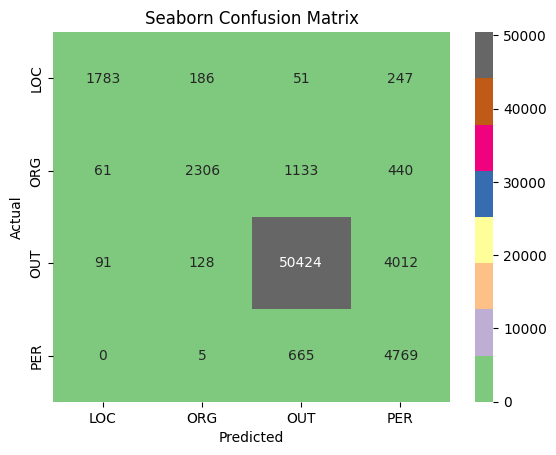

In [45]:
cm = confusion_matrix(valid_y, preds)
ax = sns.heatmap(cm, annot=True, fmt='g', cmap="Accent")

ax.set_title('Seaborn Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

## For the Tick Labels, the labels should be in Alphabetical order
# ax.xaxis.set_ticklabels(['GEOPOLIT', 'LOC', 'MEDIA', 'ORG', 'OUT', 'PER'])
ax.xaxis.set_ticklabels(['LOC', 'ORG', 'OUT', 'PER'])
ax.yaxis.set_ticklabels(['LOC', 'ORG', 'OUT', 'PER'])

plt.show()

In [42]:
# bigrams added
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    ngrams=(1, 2),
    output_sequence_length=seq_len)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)
mmodel_bi = modelNER()
mmodel_bi.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

mmodel_bi.fit( train_data, validation_data=valid_data, epochs=3)

Epoch 1/3
12432/12432 [==============================] - 370s 30ms/step - loss: 0.2735 - accuracy: 0.9169 - val_loss: 0.1978 - val_accuracy: 0.9375
Epoch 2/3
12432/12432 [==============================] - 359s 29ms/step - loss: 0.1149 - accuracy: 0.9644 - val_loss: 0.2042 - val_accuracy: 0.9402
Epoch 3/3
12432/12432 [==============================] - 370s 30ms/step - loss: 0.1016 - accuracy: 0.9672 - val_loss: 0.2074 - val_accuracy: 0.9400


2072/2072 [==============================] - 5s 2ms/step
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      2267
           1       0.88      0.59      0.71      3940
           2       0.94      1.00      0.97     54655
           3       0.99      0.69      0.82      5439

    accuracy                           0.94     66301
   macro avg       0.93      0.77      0.84     66301
weighted avg       0.94      0.94      0.94     66301



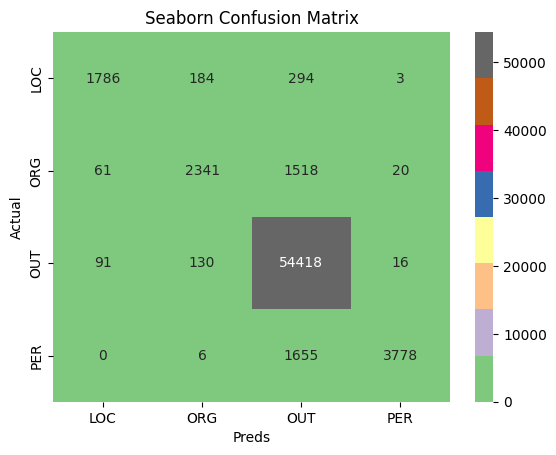

In [46]:
preds_bi = mmodel_bi.predict(valid_x)
preds_bi = np.argmax(preds_bi,axis=1)

print(classification_report(valid_y, preds_bi))

cm = confusion_matrix(valid_y, preds_bi)
ax = sns.heatmap(cm, annot=True, fmt='g', cmap="Accent")

ax.set_title('Seaborn Confusion Matrix')
ax.set_xlabel('Preds')
ax.set_ylabel('Actual')

## For the Tick Labels, the labels should be in Alphabetical order
ax.xaxis.set_ticklabels(['LOC', 'ORG', 'OUT', 'PER'])
ax.yaxis.set_ticklabels(['LOC', 'ORG', 'OUT', 'PER'])

plt.show()

In [47]:
# bigrams, trigrams & seq_len added
seq_len = 100

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    ngrams=(1, 3),
    output_sequence_length=seq_len)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)
mmodel_three = modelNER()
mmodel_three.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

mmodel_three.fit( train_data, validation_data=valid_data, epochs=3)

Epoch 1/3
12432/12432 [==============================] - 415s 33ms/step - loss: 0.2742 - accuracy: 0.9165 - val_loss: 0.1956 - val_accuracy: 0.9377
Epoch 2/3
12432/12432 [==============================] - 402s 32ms/step - loss: 0.1149 - accuracy: 0.9645 - val_loss: 0.1924 - val_accuracy: 0.9408
Epoch 3/3
12432/12432 [==============================] - 419s 34ms/step - loss: 0.1019 - accuracy: 0.9671 - val_loss: 0.2104 - val_accuracy: 0.9400


2072/2072 [==============================] - 9s 4ms/step
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      2267
           1       0.92      0.56      0.70      3940
           2       0.94      1.00      0.97     54655
           3       0.99      0.70      0.82      5439

    accuracy                           0.94     66301
   macro avg       0.94      0.77      0.84     66301
weighted avg       0.94      0.94      0.93     66301



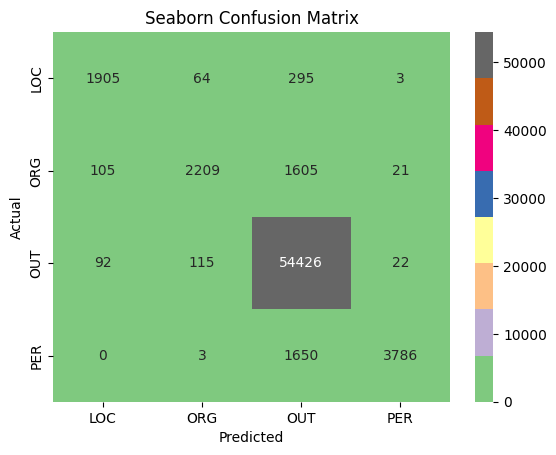

In [48]:
preds_three = mmodel_three.predict(valid_x)
preds_three = np.argmax(preds_three,axis=1)

print(classification_report(valid_y, preds_three))

cm = confusion_matrix(valid_y, preds_three)
ax = sns.heatmap(cm, annot=True, fmt='g', cmap="Accent")

ax.set_title('Seaborn Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

## For the Tick Labels, the labels should be in Alphabetical order
ax.xaxis.set_ticklabels(['LOC', 'ORG', 'OUT', 'PER'])
ax.yaxis.set_ticklabels(['LOC', 'ORG', 'OUT', 'PER'])

plt.show()